In [1]:
import numpy as np
import scipy.sparse as sparse
import scipy
import matplotlib.pyplot as plt
import generate_proj_mat as gen_proj
import generate_constant_matrices as gen_mat

np.random.seed(0)

In [2]:
N_omega = 201
N_z = 31
omega = np.linspace(-5, 5, N_omega)
z = np.linspace(0, 0.4, N_z)
delta_omega = np.abs(omega[1] - omega[0])
delta_z = np.abs(z[1] - z[0])
vp = 1
a = 1.61/1.13
vs = vp / (1 + 2 * a * vp / z[-1])
delta_v = vp*vs/(vp - vs)

In [3]:
# Can be used as part of test to see if constraint respected. 
# See if the diagonal of the computed constraint is equal to the diagonal of the 
# matrix exponential
beta_vec = 6*delta_omega * np.random.random((2*N_omega,))
beta = np.zeros((N_omega, N_omega))
for i in range(N_omega):
    for j in range(N_omega):
        beta[i][j] = beta_vec[i + j]
delta_k = np.diag((1/delta_v)*1.j*omega)
Q_plus = delta_k + beta
Q_minus = delta_k - beta
green_f = scipy.linalg.expm(delta_k*z[-1])
W_plus = np.array([scipy.linalg.expm(Q_plus * z[i]) for i in range(N_z)]).reshape(N_z*N_omega, N_omega)
W_minus = np.array([scipy.linalg.expm(Q_minus * z[i]) for i in range(N_z)]).reshape(N_z*N_omega, N_omega)
J = np.array([0.25*(W_plus[i]@W_plus[i].conj().T + W_minus[i]@W_minus[i].conj().T - 2*np.eye(N_omega)) for i in range(N_z)]).reshape(N_z*N_omega, N_omega)
propagators = np.concatenate((W_plus, W_minus))
X = np.concatenate((np.concatenate((J, propagators)), beta))

In [4]:
lin_mat = gen_mat.get_proj_lin_basic(N_omega, N_z)

In [14]:
lin_mat_for_z = lin_mat[2*N_z - 1]
real = (lin_mat_for_z@X + (lin_mat_for_z@X).conj().T)
real_should_be = 2*np.real(X[(2*N_z - 1)*N_omega: (2*N_z)*N_omega])
imag = (lin_mat_for_z@X - (lin_mat_for_z@X).conj().T)
imag_should_be = 2*1.j*np.imag(X[(2*N_z - 1)*N_omega: (2*N_z)*N_omega])
print(np.allclose(real, real_should_be))
print(np.allclose(imag, imag_should_be))

True
True


In [15]:
matmul_green_f_small_dim, skew_matmul_green_f_small_dim = gen_proj.matmul_green_f_basic_proj(omega, vp, z, N_omega)

In [16]:
test_green_f = (matmul_green_f_small_dim[-1] - matmul_green_f_small_dim[-1].conj().T).toarray()
theory_green_f = 2.j*np.imag(scipy.linalg.expm(delta_k*z[-1]))
print(np.allclose(test_green_f, theory_green_f))

True


In [17]:
hermitian_dynamics, skew_herm_dynamics = gen_mat.get_dynamics_matrices(omega, vp, z, "plus")
test_real = delta_z*X.conj().T@skew_herm_dynamics[N_z - 1]@X

In [18]:
np.trace(test_real) + np.trace(test_green_f)# - np.trace(imag)

(1.176836406102666e-14-334.82451864648107j)

In [21]:
id_green_matmul, imag_green_matmul = gen_proj.matmul_green_f_basic_proj(omega, vp, z, N_omega)
big_term = sum([delta_z*W_plus[i*N_omega:(i + 1)*N_omega]@beta@id_green_matmul[N_z - i - 1] for i in range(N_z)])
green_f_term = id_green_matmul[-1]
lin_term = lin_mat[3*N_z - 1]@X

In [22]:
2*np.trace(big_term + green_f_term - lin_term)

(702.0683151172948-334.689969096916j)

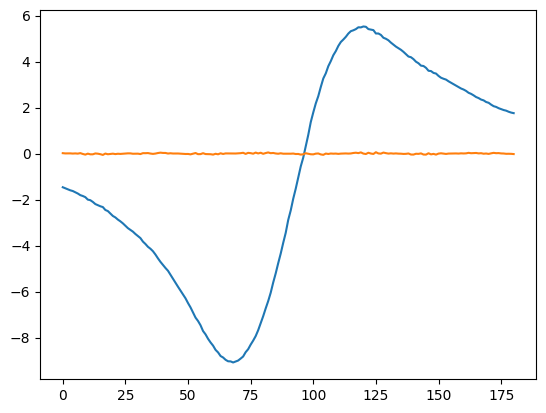

In [13]:
plt.plot(np.imag(np.diag(big_term + green_f_term, k = 20)))
plt.plot(np.imag(np.diag(lin_term, k = 20)))

In [198]:
np.zeros((1, 10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [79]:
np.trace(test_real) + np.trace(test_green_f), np.trace(real)

((507.4573674164392+1.3027773304585821e-15j), (395.5176998234558+0j))

In [28]:
sum(sum(np.abs(np.real(real - 2*should_be)))), sum(sum(np.abs(np.imag(real - 2*should_be))))

(2.2394329619190466e-13, 1.8075544306734873e-13)